# AICE Professional 시험 준비하면서 작성했던 코드에 주석을 달았습니다.

1. Tabular 데이터 Brain stroke prediction dataset
- 데이터 출처 : https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset
2. Text 데이터 Twitter Sentiment
- 데이터 출처 : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
3. Img 데이터 Flower_Classification_5class
- 데이터 출처 : https://www.kaggle.com/datasets/sauravagarwal/flower-classification

In [ ]:
# 라이브러리 임포트
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [ ]:
# 딥러닝 라이브러리 임포트
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# AICE Professional-1 Tabular 데이터 분류 모델 만들기

In [ ]:
# Tabular traindata.csv 불러오기
# df = pd.read_csv('full_data_training.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_training.csv')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
# Tabular 데이터 정보 확인
# 위의 df와 비교하면서 값하고 Dtype이 다른 부분이 있는지 확인
# 결측치 확인, 데이터 컬럼의 용도 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 전처리 - 라벨 인코딩
df['gender'] = np.where(df['gender']=='Male', 1, 0)
df['ever_married'] = np.where(df['ever_married']=='Yes', 1, 0)

In [ ]:
# Tabular 데이터 전처리 - 결측치 확인
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
avg_glucose_level,0
bmi,0
stroke,0
work_type_Private,0
work_type_Self-employed,0


In [ ]:
# 결측치가 있다면, 버리거나 평균값으로 대체

from sklearn.impute import SimpleImputer #결측치 처리 용도

features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'deck']
X = df[features]

# 수치형 데이터 결측치
numeric_features = ['age', 'fare']
numeric_imputer = SimpleImputer(strategy='mean')
X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# 범주형 데이터 결측치
categorical_features = ['embarked', 'deck', 'who', 'class', 'sex']
categorical_imputer = SimpleImputer(strategy='most_frequent')
X.loc[:, categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

# 범주형 데이터 인코딩
label_encoders = {}
for feature in categorical_features:
    # 문자열로 변환 후 인코딩
    X[feature] = X[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    X.loc[:, feature] = label_encoders[feature].fit_transform(X[feature])

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩, object인 데이터만 분류
obj_col = df.select_dtypes('object').columns
obj_col

Index(['work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [ ]:
# Tabular 데이터 전처리 - 원 핫 인코딩
df = pd.get_dummies(data=df, columns=obj_col, drop_first=True)

In [ ]:
# Tabular 데이터 컬럼 변경사항 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Private               4981 non-null   bool   
 9   work_type_Self-employed         4981 non-null   bool   
 10  work_type_children              4981 non-null   bool   
 11  Residence_type_Urban            4981 non-null   bool   
 12  smoking_status_formerly smoked  49

In [ ]:
# Tabular 데이터 feature, label 분류
features = df.drop('stroke', axis=1)
labels = df['stroke']

In [ ]:
#label
labels.value_counts()

,count
stroke,
0,4733
1,248


In [ ]:
# Tabular 데이터 Train, valid 데이터셋 분할

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((3984, 14), (997, 14), (3984,), (997,))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler_feature = ['age','avg_glucose_level', 'bmi']
df[scaler_feature] =scaler.fit_transform(df[scaler_feature])
df


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train[scaler_feature]) # 훈련 데이터에만 fit_transform
X_valid_scaled = scaler.transform(x_valid[scaler_feature])     # 테스트 데이터는 transform만

# 변환된 값들을 데이터프레임으로 다시 만듦 (컬럼 이름 유지)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=scaler_feature)
X_test_scaled_df = pd.DataFrame(X_valid_scaled, columns=scaler_feature)

df

In [ ]:
# 라이브러리 임포트
"""
머신러닝 분류 모델의 경우 아래의 것들이 성능이 좋았어서 이것들만 사용했습니다.
LogisticRegression 이 연산 속도가 빨라서 먼저 실행해보고서 어느정도의 성능이 나오는지 보고
성능이 부족한거 같으면 RandomForestClassifier와 DecisionTreeClassifier를 사용했습니다.
딥러닝 분류 모델도 만들어서 모델 성능을 비교하고 마지막에 골라서 제출했습니다.
머신러닝 회귀 모델의 경우 DecisionTreeRegressor, RandomForestRegressor, 딥러닝 CNN 모델만 사용했습니다.
"""
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Tabular LogisticRegression 머신러닝 모델 분류 성능 확인
lgr = LogisticRegression()
lgr.fit(x_train, y_train)
lgr.score(x_valid, y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9498495486459378

In [ ]:
# Tabular SGDClassifier 머신러닝 모델 분류 성능 확인
sgdc = SGDClassifier()
sgdc.fit(x_train, y_train)
sgdc.score(x_valid, y_valid)

0.9017051153460381

In [ ]:
# Tabular DecisionTreeClassifier 머신러닝 모델 분류 성능 확인
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc.score(x_valid, y_valid)

0.9037111334002006

In [ ]:
# Tabular RandomForestClassifier 머신러닝 모델 분류 성능 확인
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc.score(x_valid, y_valid)

0.9468405215646941

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
# 교차 검증 수행
cv_scores = cross_val_score(rfc, x_train, y_train, cv=5)
print(f"교차 검증 점수: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

In [ ]:
# Tabular 딥러닝 모델
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train.shape[-1], )))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax')) #저는 2개 분류~여러개 분류 모두 softmax로 통일해서 사용했습니다.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Tabular 딥러닝 모델 compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tabular 딥러닝 모델 훈련 fit
# Tabular는 es, mc, history에 숫자를 붙이지 않고 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.


es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5457 - loss: 0.8668
Epoch 1: val_loss improved from inf to 0.30950, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5465 - loss: 0.8655 - val_accuracy: 0.9498 - val_loss: 0.3095
Epoch 2/10
113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8701 - loss: 0.3780
Epoch 2: val_loss improved from 0.30950 to 0.25438, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8726 - loss: 0.3744 - val_accuracy: 0.9498 - val_loss: 0.2544
Epoch 3/10
109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9310 - loss: 0.2706
Epoch 3: val_loss improved from 0.25438 to 0.19375, saving model to best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9315 - loss: 0.2682 - val_accuracy: 0.9498 - val_loss: 0.1938
Epoch 4/10
115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9385 - loss: 0.2296
Epoch 4: val_loss improved from 0.19375 to 0.18133, 

In [ ]:
# Tabular test 데이터셋.csv 읽기
#df5 = pd.read_csv('full_data_validation.csv')
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/brain_stroke_data_validation.csv')
df5

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.555602,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.242937,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.698951,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.808410,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.378534,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
196,Male,41.0,0,0,No,Private,Rural,70.15,29.756631,formerly smoked,0
197,Male,40.0,0,0,Yes,Private,Urban,191.15,31.124172,smokes,0
198,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.798304,smokes,0
199,Male,40.0,0,0,Yes,Private,Rural,83.94,29.951301,smokes,0


In [ ]:
"""
위의 train, valid 데이터와 동일하게 대부분 데이터 전처리를 수행합니다.
훈련 데이터 셋에서는 중복, 결측치를 제거해서 모델의 분류 성능을 올려야 하지만,
테스트 데이터셋의 갯수를 줄이는 것은 (중복 삭제, 결측치 제거)는 하면 안됩니다.
저는 실습하다가 무의식적으로 하다가 지운 경우가 많았던거 같습니다.
"""
# Tabular test 데이터 전처리 - 라벨 인코딩
df5['gender'] = np.where(df5['gender']=='Male', 1, 0)
df5['ever_married'] = np.where(df5['ever_married']=='Yes', 1, 0)
df5.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [ ]:
# Tabular Test 데이터 전처리 - 원 핫 인코딩
obj_col2 = df5.select_dtypes('object').columns
df5 = pd.get_dummies(data=df5, columns=obj_col2, drop_first=True)

In [ ]:
# Tabular Test 데이터 feature, label 분류
x_test = df5.drop('stroke', axis=1)
y_test = df5['stroke']

In [ ]:
# Tabular Test 데이터로 머신러닝, 딥러닝 모델 성능 예측
lgr_y_pred = lgr.predict(x_test)
sgdc_y_pred = sgdc.predict(x_test)
dtc_y_pred = dtc.predict(x_test)
rfc_y_pred = rfc.predict(x_test)
model_y_pred = model.predict(x_test)
model_y_pred = np.argmax(model_y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [ ]:
lgr_y_pred, sgdc_y_pred, dtc_y_pred, rfc_y_pred, model_y_pred, model_y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0,

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print("\n최종 테스트 정확도:", accuracy_score(labels_test, rfc_y_pred))
print("\n분류 보고서:")
print(classification_report(labels_test, rfc_y_pred))

In [ ]:
# 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(x_train, y_train)
print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.3f}")

In [ ]:
# 최적화된 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(features_test)
print("\n최종 테스트 정확도:", accuracy_score(labels_test, y_pred))
print("\n분류 보고서:")
print(classification_report(features_test, y_pred))

# 특성 선택
selector = SelectFromModel(best_model, prefit=True)
X_train_selected = selector.transform(x_train)
X_test_selected = selector.transform(X_test)

# 선택된 특성으로 최종 모델 학습
final_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_model.fit(X_train_selected, y_train)


In [ ]:
"""
시험에서는 TestDataset에 대한 라벨이 부여되지 않아 아래와 같이 확인이 가능하지 않습니다.
현재 테스트 데이터셋은 라벨도 있고, 모델 성능이 비슷해보여서 비교하는 과정을 가졌습니다.

LogisticRegression 훈련 데이터셋 성능: 0.9498 (95%)
SGDClassifier 훈련 데이터셋 성능: 0.9498 (95%)
DecisionTreeClassifier 훈련 데이터셋 성능: 0.9067 (91%)
RandomForestClassifier 훈련 데이터셋 성능: 0.9478 (95%)
딥러닝 모델 훈련 데이터셋 성능: 0.9498 (95%)

시험 환경이었다면 모델성능이 비슷하다고 느껴지면
다른 실습 과정에서도 대부분 좋은 성능을 내는건 아래의 두 모델이라
RandomForestClassifier, 딥러닝 모델중 하나를 제출했을거 같습니다.

"""

In [ ]:
# Tabular 데이터 분류 시각화
from sklearn.metrics import classification_report, confusion_matrix

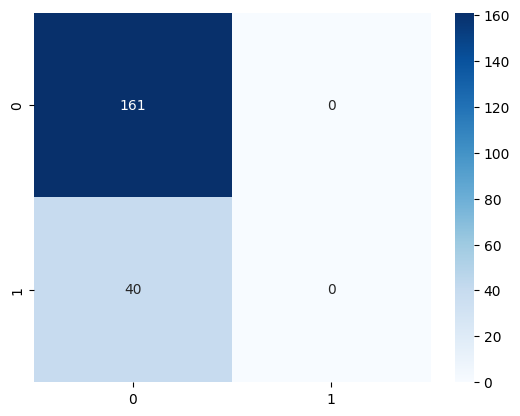

In [ ]:
# Logistic Regression 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, lgr_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

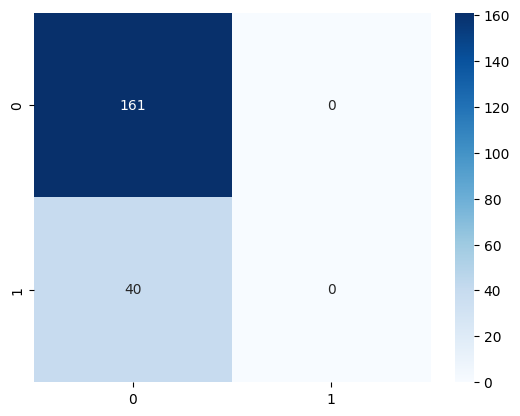

In [ ]:
# SGDC Classifier 모델 성능 - 훈련이 잘못된거 같아요.
cm = confusion_matrix(y_test, sgdc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

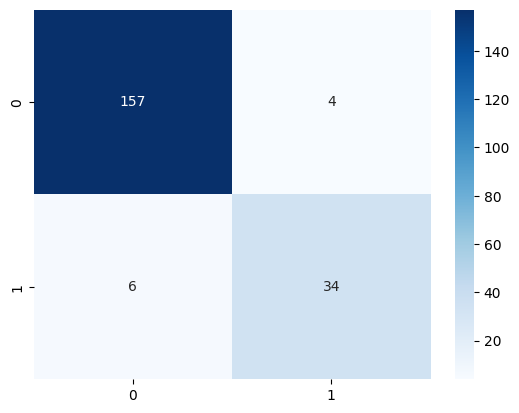

In [ ]:
# DecisionTreeClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다.
cm = confusion_matrix(y_test, dtc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

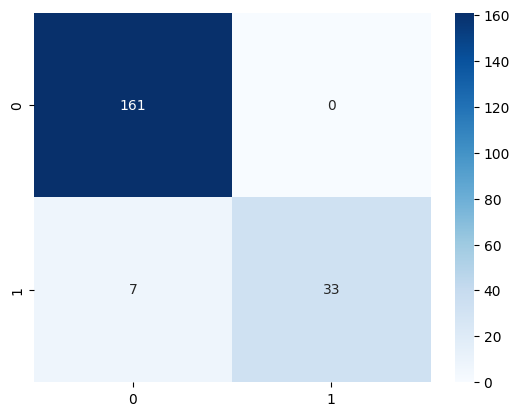

In [ ]:
# RandomForestClassifier 모델 성능 - 오 분류 성능이 꽤 좋아보입니다. DecisionTree와 비슷한 성능인거 같네요.
cm = confusion_matrix(y_test, rfc_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

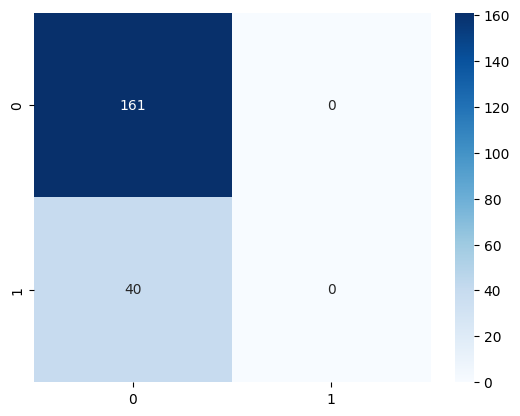

In [ ]:
# 딥러닝 모델 성능 - 모델이 다 0을 예측해서 좋은거처럼 보였던거 같네요
cm = confusion_matrix(y_test, model_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# 모델중에 가장 성능이 좋아보이는 DecisionTreeClassifier의 예측값을 테스트 데이터셋 csv에 추가
df5['pred'] = rfc_y_pred
df5

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


In [ ]:
# 테스트 데이터셋 모델 성능 확인 - 안해도 되는 작업이지만 라벨이 있어서 한번 더 확인해봤습니다.
correct_count = sum(df5['stroke']==df5['pred'])
total_count = len(df5)
model_accuracy = correct_count/total_count
print(f'model_accuracy : {model_accuracy:.2f}')

model_accuracy : 0.97


In [ ]:
# Tabular 머신러닝 모델 저장을 위한 joblib 라이브러리 임포트
import joblib
joblib.dump(rfc, '01012345678_1.joblib') # Tabular 데이터는 '연락처_1.joblib' 으로 저장

['01012345678_1.joblib']

In [ ]:
# Tabular 모델 저장 확인
tab_load_model = joblib.load('01012345678_1.joblib')

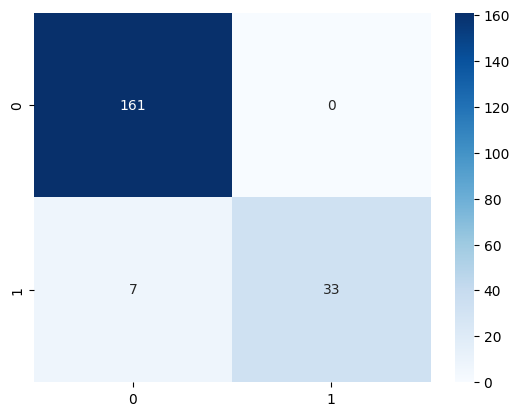

In [ ]:
# Tabular 모델 불러와서 모델 성능 확인 / 시험에서는 불필요
tab_load_y_pred = tab_load_model.predict(x_test)
cm = confusion_matrix(y_test, tab_load_y_pred)
sns.heatmap(data=cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Tabular 모델 테스트 데이터셋.csv 저장
df5.to_csv('01012345678_1.csv', index=False, encoding='utf-8') # Tabular 데이터는 '연락처_1.csv' 으로 저장
df6 = pd.read_csv('01012345678_1.csv') # 데이터 저장 확인
df6

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,pred
0,0,61.0,0,0,1,202.21,31.555602,1,False,True,False,False,False,True,False,0
1,0,59.0,0,0,1,76.15,30.242937,1,True,False,False,False,False,False,False,1
2,1,78.0,0,1,1,219.84,30.698951,1,True,False,False,True,False,False,False,1
3,1,57.0,0,1,0,217.08,33.808410,1,False,False,False,True,False,False,False,0
4,1,58.0,0,0,1,189.84,31.378534,1,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,1,41.0,0,0,0,70.15,29.756631,0,True,False,False,False,True,False,False,0
197,1,40.0,0,0,1,191.15,31.124172,0,True,False,False,True,False,False,True,0
198,0,45.0,1,0,1,95.02,31.798304,0,False,False,False,False,False,False,True,0
199,1,40.0,0,0,1,83.94,29.951301,0,True,False,False,False,False,False,True,0


## Version2 (titanic dataset)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 데이터 로드
# seaborn에서 titanic 데이터셋 불러오기
df = sns.load_dataset('titanic')

print("원본 데이터프레임 정보:")
df.info()
print("\n원본 데이터프레임 상위 5행:")
print(df.head())
print("\n원본 데이터프레임 결측치:")
print(df.isnull().sum())

# 2. 특성(X)과 타겟(y) 분리
# 'survived' 컬럼이 타겟 변수
X = df.drop('survived', axis=1)
y = df['survived']

# 불필요하거나 중복되는 컬럼 제거 (도메인 지식 기반)
# 'alone'은 'sibsp'와 'parch'로 유도 가능하고, 'who'는 'sex'와 'age'로 유도 가능.
# 'deck'은 결측치가 너무 많고(약 77%), 'embark_town'은 'embarked'와 동일한 정보.
# 'class'는 'pclass'와 중복. 'fare'는 'pclass'와 연관성이 높음.
# 'sibsp', 'parch'는 'family_size'로 합쳐서 활용.
X = X.drop(['alive', 'alone', 'who', 'embark_town', 'class'], axis=1)
# Cabin (deck)은 결측치가 많아 나중에 처리하거나 제거하는 것을 고려할 수 있으나, 여기서는 포함시켜 처리.

# 'sex'와 'embarked' 컬럼에서 'NaN'값 처리 - SimpleImputer에 의해 처리될 것임.
# age의 NaN은 SimpleImputer로 처리.
# embark_town은 embark_town과 embarked가 같은 정보라서 embarked만 남김 (위에서 제거).

print("\n정제 후 특성 데이터프레임 상위 5행:")
print(X.head())
print("\n정제 후 특성 데이터프레임 결측치:")
print(X.isnull().sum())


# 3. 훈련 세트와 테스트 세트 분리 (가장 중요!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y는 타겟 변수의 클래스 비율을 훈련/테스트 세트에 동일하게 유지. 분류 문제에서 중요.

print(f"\n훈련 세트 크기: {X_train.shape}")
print(f"테스트 세트 크기: {X_test.shape}")


# 4. 전처리 파이프라인 구축 (ColumnTransformer 사용)

# 수치형 컬럼과 범주형 컬럼 정의
# 'age', 'fare'는 수치형 (결측치 있음)
# 'pclass', 'sibsp', 'parch'는 범주형으로도 볼 수 있지만, 여기서는 수치형으로 유지하고 스케일링.
# 'sex', 'embarked'는 범주형
numerical_features = ['age', 'fare', 'pclass', 'sibsp', 'parch']
categorical_features = ['sex', 'embarked']

# ColumnTransformer를 사용하여 각 컬럼 타입에 맞는 전처리 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')), # 수치형 결측치 평균으로 대체
            ('scaler', StandardScaler())                  # 표준화 스케일링
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')), # 범주형 결측치 최빈값으로 대체
            ('onehot', OneHotEncoder(handle_unknown='ignore'))     # 원-핫 인코딩
        ]), categorical_features)
    ],
    remainder='drop' # 위에 명시되지 않은 컬럼은 제거 (예: 'deck', 'embarked_town', 'class', 'who' 등은 이미 제거됨)
)

# 5. 모델 파이프라인 정의 (전처리 + 모델)
# RandomForestClassifier 모델을 Pipeline에 추가
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42)) # 분류기
])

# 6. 모델 학습
print("\n모델 학습 시작...")
model_pipeline.fit(X_train, y_train)
print("모델 학습 완료.")

# 7. 예측 및 평가
y_pred = model_pipeline.predict(X_test)

print("\n테스트 세트 예측 결과:")
print(f"정확도 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print("\n혼동 행렬 (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred))
print("\n분류 보고서 (Classification Report):")
print(classification_report(y_test, y_pred))

# 8. 교차 검증 (선택 사항, 모델의 일반화 성능 검증)
print("\n교차 검증 (Cross-validation) 수행 중...")
# 파이프라인을 그대로 cross_val_score에 전달
cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)
# n_jobs=-1은 사용 가능한 모든 코어를 사용하여 병렬 처리
print(f"5-Fold Cross-validation 평균 정확도: {cv_scores.mean():.4f}")
print(f"5-Fold Cross-validation 정확도 표준편차: {cv_scores.std():.4f}")


# 9. 하이퍼파라미터 튜닝 (GridSearchCV 예시 - 시간이 오래 걸릴 수 있음)
print("\n하이퍼파라미터 튜닝 (GridSearchCV) 시작 (시간이 다소 소요될 수 있습니다)...")
param_grid = {
    'classifier__n_estimators': [100, 200, 300], # RandomForestClassifier의 n_estimators
    'classifier__max_features': ['sqrt', 'log2'], # RandomForestClassifier의 max_features
    'classifier__max_depth': [5, 10, None], # RandomForestClassifier의 max_depth
    'classifier__min_samples_leaf': [1, 2, 4] # RandomForestClassifier의 min_samples_leaf
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("\n최적의 하이퍼파라미터:")
print(grid_search.best_params_)
print(f"최고 교차 검증 정확도: {grid_search.best_score_:.4f}")

# 최적 모델로 테스트 세트 예측 및 평가
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
print(f"\n튜닝된 모델의 테스트 세트 정확도: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\n튜닝된 모델의 분류 보고서:")
print(classification_report(y_test, y_pred_tuned))

원본 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB

원본 데이터프레임 상위 5행:
   survived  pclass     sex   age  sibsp  parch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드
df = sns.load_dataset('titanic')

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [ ]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [ ]:
# NaN이 많은 값과 중복되는 의미를 가지는 컬럼을 삭제,
#여기서는 class와 alive를 삭제하면 라벨인코딩을 안해도 되지만 라벨인코딩 테스트를 위해 선택한
df.drop(columns=['deck','survived','pclass','who'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   age          714 non-null    float64 
 2   sibsp        891 non-null    int64   
 3   parch        891 non-null    int64   
 4   fare         891 non-null    float64 
 5   embarked     889 non-null    object  
 6   class        891 non-null    category
 7   adult_male   891 non-null    bool    
 8   embark_town  889 non-null    object  
 9   alive        891 non-null    object  
 10  alone        891 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(2), object(4)
memory usage: 58.6+ KB


In [ ]:
features = df.drop('alive', axis=1)
labels = df['alive']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
df['sex'] = np.where(df['sex']=='male',1,0)
df['alive'] = np.where(df['alive']=='yes',1,0)
df

,sex,age,sibsp,parch,fare,embarked,class,adult_male,embark_town,alive,alone
0,1,22.0,1,0,7.2500,S,Third,True,Southampton,0,False
1,0,38.0,1,0,71.2833,C,First,False,Cherbourg,1,False
2,0,26.0,0,0,7.9250,S,Third,False,Southampton,1,True
3,0,35.0,1,0,53.1000,S,First,False,Southampton,1,False
4,1,35.0,0,0,8.0500,S,Third,True,Southampton,0,True
...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.0,0,0,13.0000,S,Second,True,Southampton,0,True
887,0,19.0,0,0,30.0000,S,First,False,Southampton,1,True
888,0,NaN,1,2,23.4500,S,Third,False,Southampton,0,False
889,1,26.0,0,0,30.0000,C,First,True,Cherbourg,1,True


In [ ]:
df['class'].value_counts()

,count
class,
Third,491
First,216
Second,184


In [ ]:
class_encoder = LabelEncoder()


In [ ]:
obj_col = df.select_dtypes('object').columns
df = pd.get_dummies(df, columns=obj_col, drop_first=True)
df

,sex,age,sibsp,parch,fare,class,adult_male,alive,alone,embarked_Q,embarked_S,embark_town_Queenstown,embark_town_Southampton
0,1,22.0,1,0,7.2500,Third,True,0,False,False,True,False,True
1,0,38.0,1,0,71.2833,First,False,1,False,False,False,False,False
2,0,26.0,0,0,7.9250,Third,False,1,True,False,True,False,True
3,0,35.0,1,0,53.1000,First,False,1,False,False,True,False,True
4,1,35.0,0,0,8.0500,Third,True,0,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,27.0,0,0,13.0000,Second,True,0,True,False,True,False,True
887,0,19.0,0,0,30.0000,First,False,1,True,False,True,False,True
888,0,NaN,1,2,23.4500,Third,False,0,False,False,True,False,True
889,1,26.0,0,0,30.0000,First,True,1,True,False,False,False,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   sex                      891 non-null    int64   
 1   age                      714 non-null    float64 
 2   sibsp                    891 non-null    int64   
 3   parch                    891 non-null    int64   
 4   fare                     891 non-null    float64 
 5   class                    891 non-null    category
 6   adult_male               891 non-null    bool    
 7   alive                    891 non-null    int64   
 8   alone                    891 non-null    bool    
 9   embarked_Q               891 non-null    bool    
 10  embarked_S               891 non-null    bool    
 11  embark_town_Queenstown   891 non-null    bool    
 12  embark_town_Southampton  891 non-null    bool    
dtypes: bool(6), category(1), float64(2), int64(4)
memory usage: 48.1 

In [ ]:
df['sex'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# 1. 필요한 특성 선택
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'deck']
X = df[features]
X

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,deck
0,3,male,22.0,1,0,7.2500,S,Third,man,NaN
1,1,female,38.0,1,0,71.2833,C,First,woman,C
2,3,female,26.0,0,0,7.9250,S,Third,woman,NaN
3,1,female,35.0,1,0,53.1000,S,First,woman,C
4,3,male,35.0,0,0,8.0500,S,Third,man,NaN
...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S,Second,man,NaN
887,1,female,19.0,0,0,30.0000,S,First,woman,B
888,3,female,NaN,1,2,23.4500,S,Third,woman,NaN
889,1,male,26.0,0,0,30.0000,C,First,man,C


In [ ]:
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['alive'])

# AICE Professional-2 Text 분류 모델 만들기

## Version1 (Bert)

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
text_df = pd.read_csv('https://github.com/ohgzone/file1/raw/main/aihub_coupus.csv' )

# xlsx의 경우 text_df = pd.read_excel('https://github.com/ohgzone/file1/raw/main/aihub_coupus.xlsx', engine='openpyxl')


In [ ]:
text_df.isnull().sum()

,0
감정,0
문장,0


In [ ]:
text_df['감정'].value_counts()

,count
감정,
불안,9320
분노,9160
상처,9143
슬픔,9125
당황,8756
기쁨,6126


In [ ]:
text_label = {'불안':0, '분노':1, '상처':2, '슬픔':3, '당황':4, '기쁨':5}
text_df['감정']=text_df['감정'].map(text_label)
text_df

,감정,문장
0,1,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,1,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,1,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,1,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...,...,...
51625,1,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.
51626,0,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.
51627,2,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.
51628,0,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.


In [ ]:
text_features = text_df.문장.to_list()
text_labels = text_df.감정.to_list()

text_features[:2], text_labels[:2]

(['일은 왜 해도 해도 끝이 없을까? 화가 난다.',
  '이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.'],
 [1, 1])

In [ ]:
from sklearn.model_selection import train_test_split

text_x_train, text_x_valid, text_y_train, text_y_valid = train_test_split(text_features, text_labels, stratify=text_labels, random_state=42, test_size=0.2)

len(text_x_train), len(text_x_valid), len(text_y_train), len(text_y_valid)

(41304, 10326, 41304, 10326)

In [ ]:
text_x_train[:2]

['회사에서 새로 들어온 사원이 계속해서 일을 물어봐. 너무 성가셔.',
 '공장에서 일한 지 벌써 사십 년이 다 돼가는데 고작 무릎질환으로 나를 해고하다니. 허탈해.']

In [ ]:
bert_model = 'klue/bert-base'

In [ ]:
from transformers import AutoConfig, BertTokenizerFast, TFBertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained(bert_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/495k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

32000

In [ ]:
train_encodings = tokenizer(text_x_train, truncation=True, padding=True)
valid_encodings = tokenizer(text_x_valid, truncation=True, padding=True)

In [ ]:
print(train_encodings['input_ids'][0])

[2, 3769, 27135, 3755, 8182, 6200, 2052, 3851, 6396, 1507, 2069, 9288, 2998, 18, 3760, 18796, 2415, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(valid_encodings['input_ids'][0])

[2, 1299, 2069, 3732, 5012, 2259, 3949, 2170, 2318, 11466, 5012, 7245, 15645, 2138, 1902, 13964, 7261, 732, 2116, 4054, 2170, 8086, 2205, 2318, 859, 2359, 2051, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), text_y_train))
train_dataset = train_dataset.shuffle(1000).batch(16).cache().prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encodings), text_y_valid))
valid_dataset = train_dataset.shuffle(1000).batch(16).cache().prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:

#train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), text_y_train))
#train_dataset = train_dataset.shuffle(1000).batch(16).cache().prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "token_type_ids": train_encodings["token_type_ids"],
    },
    tf.constant(text_y_train, dtype=tf.int32) # <-- 레이블을 tf.constant로 변환
))
train_dataset = train_dataset.shuffle(len(text_y_train)).batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)


#valid_dataset = tf.data.Dataset.from_tensor_slices((dict(valid_encodings), text_y_valid))
#valid_dataset = train_dataset.shuffle(1000).batch(16).cache().prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": valid_encodings["input_ids"],
        "attention_mask": valid_encodings["attention_mask"],
        "token_type_ids": valid_encodings["token_type_ids"],
    },
    tf.constant(text_y_valid, dtype=tf.int32) # <-- 레이블을 tf.constant로 변환
))
# 검증 데이터는 일반적으로 셔플하지 않습니다.
valid_dataset = valid_dataset.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)



In [ ]:
config = AutoConfig.from_pretrained(bert_model)
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

In [ ]:
#몇개로 분류할거냐(감정 몇개냐) num_label = 2, 파이토치 학슨된 정보를 tensorflow 로 불러 from_pt=True
model = TFBertForSequenceClassification.from_pretrained(bert_model, num_labels=6, from_pt=True)
from transformers import TFAutoModelForSequenceClassification

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(train_dataset, epochs=10, validation_data=(valid_dataset))


Epoch 1/10
 739/2582 [=======>......................] - ETA: 9:13 - loss: 1.3471 - accuracy: 0.4674

In [ ]:
model.summary()

In [ ]:
text_df5 = pd.read_csv('https://github.com/ohgzone/file1/raw/main/aihub_coupus.csv' )
text_df5 = text_df5.drop('감정')
text_df5

In [ ]:
text_valid5 = text_df5['문장'].to_list()

text_encodings5 = tokenizer(text_valid5, truncation=True, padding=True)

text_valid_dataset5 = tf.data.Dataset.from_tensor_slices((dict(text_encodings5)))
text_valid_dataset5 = text_valid_dataset5.batch(16)

predictions = model.predict(text_valid_dataset5)

In [ ]:
# logits에서 클래스 예측값으로 변환
predicted_labels = np.argmax(predictions.logits, axis=1)

# 실제 레이블 변환
#text_label = {'불안':0, '분노':1, '상처':2, '슬픔':3, '당황':4, '기쁨':5}
label_text = {0:'불안', 1:'분노', 2:'상처', 3:'슬픔', 4:'당황', 5:'기쁨'}
true_labels =text_df5['감정'].map(label_text)


# 정확도 계산
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(true_labels, predicted_labels)
print(f'정확도: {accuracy:.4f}')

# 상세한 분류 보고서 출력
print('\n분류 보고서:')
print(classification_report(true_labels, predicted_labels,
                          target_names=['불안', '분노', '상처', '슬픔', '당황', '기쁨']))





In [ ]:

# Text Test 데이터셋.csv 저장 및 불러와서 확인
text_df5.to_csv('01012345678_2.csv', index=False, encoding='utf-8')
text_df6 = pd.read_csv('01012345678_2.csv')
text_df6

## Version2 (Basic)

In [ ]:
# Text train 데이터.csv 읽기
# column이 없는 데이터셋이라 header를 None으로 하고 임의로 라벨을 지정해서 사용할 예정입니다.
#text_df = pd.read_csv('twitter_training.csv', header=None)
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

text_df = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/twitter_training.csv', header=None)
text_df

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:

# Text 데이터 전처리 - 감정 분류에 불필요한 데이터셋 제거
text_df = text_df.drop([0, 1], axis=1)

In [ ]:
# Text 데이터 전처리 - column 임의로 지정 label, text
text_df = text_df.rename(columns={2:'label', 3:'text'})
text_df

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [ ]:
# Text 데이터 전처리 - 결측치 확인
text_df.isnull().sum()

,0
label,0
text,686


In [ ]:
# Text 데이터 전처리 - 결측치 확인
text_df = text_df.dropna()

In [ ]:
# Text 데이터 전처리 - 불용어 여부 확인
# '[^a-zA-Z ]' 으로 적으면 소문자, 대문자, 공백 제외 다른 문자나 숫자가 있는지 확인
# '[^가-힣 ]' 으로 적으면 한글, 공백 제외 다른 문자나 숫자가 있는지 확인
# '[^a-zA-Z가-힣 ]' 으로 적으면 영문, 한글, 공백 제외
# [^a-zA-Z가-힣] <- 공백이 없이 만들면 이후 작업에서 띄어쓰기에 필요한 공백을 모두 제거해버려서 문제가 됩니다.

text_df[text_df['text'].str.contains('[^a-zA-Z ]')].head(3)

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


In [ ]:
# Text 영문자 제외 모두 ''으로 변경
text_df['text'] = text_df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
# Text 문자열의 앞뒤 공백을 제거
text_df['text'] = text_df['text'].str.strip()
# Text 소문자로 변경
text_df['text'] = text_df['text'].str.lower()
# Text 중복 여부 확인 / 6997개 인 것 확인
text_df['text'].duplicated().sum()

<ipython-input-46-4ef7be13015a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text'] = text_df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
<ipython-input-46-4ef7be13015a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['text'] = text_df['text'].str.strip()
<ipython-input-46-4ef7be13015a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

np.int64(6997)

In [ ]:
# Text 중복 제거
text_df.drop_duplicates(subset='text', inplace=True)

<ipython-input-47-8fbce50339b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df.drop_duplicates(subset='text', inplace=True)


In [ ]:
# Text 중복 제거 확인
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66999 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   66999 non-null  object
 1   text    66999 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
# Text 라벨이 어떤 종류가 있는지 확인
text_df['label'].value_counts()

,count
label,
Negative,20455
Positive,18215
Neutral,16519
Irrelevant,11810


In [ ]:
# Text 라벨 인코딩
text_class_to_label = {'Negative':0, 'Positive':1, 'Neutral':2, 'Irrelevant':3}
text_df['label'] = text_df['label'].map(text_class_to_label)

<ipython-input-50-6d2bea400fac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['label'] = text_df['label'].map(text_class_to_label)


In [ ]:
# Text 라벨 인코딩 제대로 되었는지 확인
text_df['label'].value_counts()

,count
label,
0,20455
1,18215
2,16519
3,11810


In [ ]:
# Text feature, label 분류
text_features = text_df['text']
text_labels = text_df['label']

In [ ]:
# Text train, valid 데이터셋 나누기
text_x_train, text_x_valid, text_y_train, text_y_valid = train_test_split(text_features, text_labels, test_size=0.2, random_state=42, stratify=text_labels)
text_x_train.shape, text_x_valid.shape, text_y_train.shape, text_y_valid.shape

((53599,), (13400,), (53599,), (13400,))

In [ ]:
# Text 분류, TFIDF-머신러닝 모델로 분류하기
# 사용방법이 비교적 단순하고 전처리도 거의 없어서 먼저 해봅니다.
# TF-IDF는 텍스트가 포함된 벡터의 특성에 따라 각 단어의 가중치를 계산하고,
# 그 가중치를 이용해 문서나 텍스트를 분류하거나 회귀 모델에 입력으로 사용합니다.

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
text_x_train_v = tfidf.fit_transform(text_x_train)
text_x_valid_v = tfidf.transform(text_x_valid)

In [ ]:
# Text LogisticRegression 모델 성능 확인
text_lgr = LogisticRegression()
text_lgr.fit(text_x_train_v, text_y_train)
text_lgr.score(text_x_valid_v, text_y_valid)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7642537313432836

In [ ]:
# Text SGDClassifer 모델 성능 확인
text_sgdc = SGDClassifier()
text_sgdc.fit(text_x_train_v, text_y_train)
text_sgdc.score(text_x_valid_v, text_y_valid)

0.7161940298507463

In [ ]:
# Text DecisionTreeClassifier 모델 성능 확인
text_dtc = DecisionTreeClassifier()
text_dtc.fit(text_x_train_v, text_y_train)
text_dtc.score(text_x_valid_v, text_y_valid)

0.7198507462686567

In [ ]:
# Text RandomForestClassifier 모델 성능 확인
text_rfc = RandomForestClassifier()
text_rfc.fit(text_x_train_v, text_y_train)
text_rfc.score(text_x_valid_v, text_y_valid)

0.9085820895522388

In [ ]:
# Text Tokenizer - 딥러닝 분석을 위한 라이브러리 임포트
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Text Tokenizer 작업
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_x_train)

In [ ]:
# Tokenizer에 학습한 단어가 어떤게 있는지 확인용입니다. 작성하지 않아도 괜찮아요.
print(tokenizer.word_index)

In [ ]:
# Tokenizer에 학습한 단어별 빈도 수 확인용입니다. 작성하지 않아도 괜찮아요.
print(tokenizer.word_counts)

In [ ]:
# Tokenizer가 학습한 단어의 개수를 확인합니다.
max_words = len(tokenizer.word_index)
max_words

35958

In [ ]:
# Tokenizer 시퀀스 작업
text_x_train_seq = tokenizer.texts_to_sequences(text_x_train)
text_x_valid_seq = tokenizer.texts_to_sequences(text_x_valid)

In [ ]:
# Tokenizer 시퀀스 작업 후 가장 긴 문장의 단어 개수를 찾습니다.
max(len(i) for i in text_x_train_seq)

166

In [ ]:
# Tokenizer 시퀀스 이후 pad 작업을 하여 가장 긴 문장의 단어수에 맞춰서 공백을 0으로 채워줍니다.
text_x_train_pad = pad_sequences(text_x_train_seq, maxlen=166)
text_x_valid_pad = pad_sequences(text_x_valid_seq, maxlen=166)

In [ ]:
# Text label 갯수 확인용 (4개)
text_labels.value_counts()

,count
label,
0,20455
1,18215
2,16519
3,11810


In [ ]:
# Text 딥러닝 모델
text_model = Sequential()
text_model.add(Embedding(input_dim=max_words+1, output_dim=100, input_length=166))
text_model.add(Bidirectional(LSTM(16, return_sequences=True)))
text_model.add(Dropout(0.3))
text_model.add(Bidirectional(LSTM(16, return_sequences=False)))
text_model.add(Dropout(0.3))
text_model.add(Dense(64, activation='swish'))
text_model.add(BatchNormalization())
text_model.add(Dropout(0.3))
text_model.add(Dense(4, activation='softmax')) # 위에서 수행한 text label 개수

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Text 딥러닝 모델 compile
text_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Text는 es2, mc2, history2 처럼 변수에 2를 붙여서 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
mc2 = ModelCheckpoint('best_text_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history2 = text_model.fit(
    text_x_train_pad, text_y_train,
    epochs=5,
    batch_size=512,
    validation_data=(text_x_valid_pad, text_y_valid),
    callbacks=[es2, mc2],
    verbose=1
)

Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4364 - loss: 1.2234
Epoch 1: val_loss improved from inf to 1.25177, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.4376 - loss: 1.2216 - val_accuracy: 0.5882 - val_loss: 1.2518
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8288 - loss: 0.4851
Epoch 2: val_loss improved from 1.25177 to 0.96368, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8290 - loss: 0.4846 - val_accuracy: 0.7831 - val_loss: 0.9637
Epoch 3/5
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9267 - loss: 0.2259
Epoch 3: val_loss improved from 0.96368 to 0.57318, saving model to best_text_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9267 - loss: 0.2259 - val_accuracy: 0.8449 - val_loss: 0.5732
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9445 - loss: 0.1625
Epoch 4: val_loss improved from 0.5

In [ ]:
# 위의 Text 모델 성능은 0.873이 나왔네요.
# Text Test 데이터셋.csv 불러오기
# 시험에서는 위와 비슷한 명칭으로 데이터를 불러서 사용합니다.

text_df5 = pd.read_csv('https://raw.githubusercontent.com/suku-7/AICE-Pro-share/refs/heads/main/twitter_validation.csv', header=None)
text_df5

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [ ]:
# Text Test 데이터셋 전처리 - 불필요한 column 삭제, 결측치 확인
text_df5 = text_df5.drop([0, 1], axis=1)
text_df5 = text_df5.rename(columns={2:'label', 3:'text'})
text_df5.isnull().sum()

,0
label,0
text,0


In [ ]:
# Text Test 데이터셋 전처리 - 불용어 여부 확인
text_df5[text_df5['text'].str.contains('[^a-zA-Z ]')].head(3)

,label,text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...


In [ ]:
# Text Test 데이터셋 불용어 제거
text_df5['text'] = text_df5['text'].str.replace('[^a-zA-Z ]', '', regex=True)
# Text Test 데이터셋 앞뒤에 공백 제거
text_df5['text'] = text_df5['text'].str.strip()
# Text Test 데이터셋 소문자로 변경
text_df5['text'] = text_df5['text'].str.lower()
# Text Test 데이터셋 중복 여부, 갯수 확인
text_df5['text'].duplicated().sum()

# Train Data와 다르게 Test 데이터셋은 중복이 있어도 지우지 않았습니다.

np.int64(3)

In [ ]:
# Text Test 데이터셋 라벨 종류, 갯수 확인
text_df5['label'].value_counts()

,count
label,
Neutral,285
Positive,277
Negative,266
Irrelevant,172


In [ ]:
# Text Test 데이터셋 라벨 인코딩, 제대로 되었는지 확인 (Train 데이터셋하고 동일하게)
text_class_to_label = {'Negative':0, 'Positive':1, 'Neutral':2, 'Irrelevant':3}
text_df5['label'] = text_df5['label'].map(text_class_to_label)
text_df5['label'].value_counts()

,count
label,
2,285
1,277
0,266
3,172


In [ ]:
# Text Test 데이터셋 feature, label 분류
text_x_test = text_df5['text']
text_y_test = text_df5['label']
# Text Test 데이터 모델 성능 확인을 위해 데이터 전처리, Tfidf, Tokenizer
text_x_test_v = tfidf.transform(text_x_test)
text_x_test_seq = tokenizer.texts_to_sequences(text_x_test)
text_x_test_pad = pad_sequences(text_x_test_seq)

In [ ]:
# Text Test 데이터셋 모델로 예측하기.
text_rfc_y_pred = text_rfc.predict(text_x_test_v)
text_model_y_pred = text_model.predict(text_x_test_pad)
text_model_y_pred = np.argmax(text_model_y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


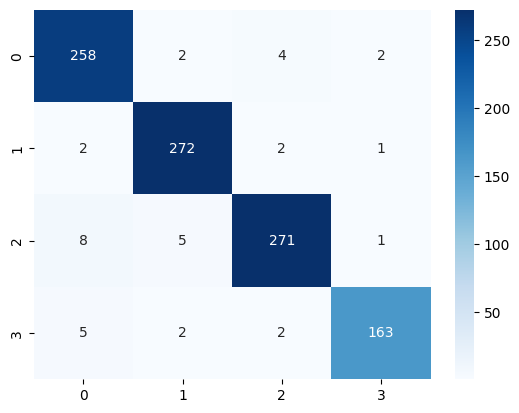

In [ ]:
# Text Test 데이터셋에 label이 있어서 예측한 것과 비교용으로 시각화 하였습니다.
# 시험에서는 label이 없기 때문에 확인할 수 없습니다.
# Text RandomForestClassifier 모델
text_cm = confusion_matrix(text_y_test, text_rfc_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

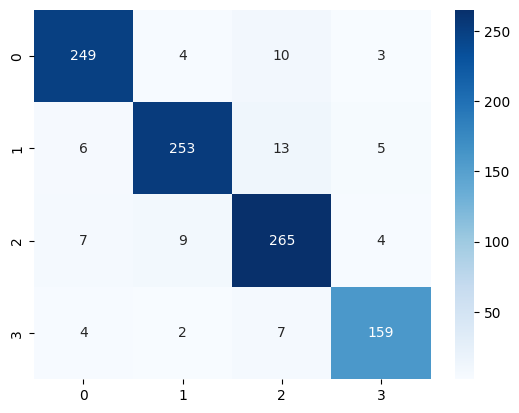

In [ ]:
# Text 딥러닝 모델
text_cm = confusion_matrix(text_y_test, text_model_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [ ]:
# Text RandomForestClassifier는 훈련 데이터셋 기준 0.908
# Text 딥러닝은 훈련 데이터셋 기준 0.873이 나와서 RandomForest 모델을 선택했습니다.
# Text 데이터 라벨이 4개인 분류인데 96% 성능이면 꽤 좋은거 같습니다.
# 위에서도 말씀드렸지만, Test Dataset에 라벨이 있기 때문에 예측값과 비교한 부분입니다.
# 시험에서는 불필요한 부분입니다.

text_df5['pred'] = text_rfc_y_pred
text_correct_count = sum(text_df5['label']==text_df5['pred'])
text_total_count = len(text_df5)
text_model_accuracy = text_correct_count/text_total_count
print(f'text_model_accuracy : {text_model_accuracy:.2f}')

text_model_accuracy : 0.96


In [ ]:
# Text dataset에 예측한 값을 csv에 추가
text_df5['pred'] = text_rfc_y_pred
text_df5

,label,text,pred
0,3,i mentioned on facebook that i was struggling ...,3
1,2,bbc news amazon boss jeff bezos rejects claim...,2
2,0,microsoft why do i pay for word when it functi...,0
3,0,csgo matchmaking is so full of closet hacking ...,0
4,2,now the president is slapping americans in the...,2
...,...,...,...
995,3,toronto is the arts and culture capital of can...,3
996,3,this is actually a good move tot bring more vi...,3
997,1,today sucked so its time to drink wine n play ...,1
998,1,bought a fraction of microsoft today small wins,1


In [ ]:
# Text dataset 라벨 인코딩 했던 것 원상태로
text_label_to_class = {0:'Negative', 1:'Positive', 2:'Neutral', 3:'Irrelevant'}
text_df5['label'] = text_df5['label'].map(text_label_to_class)
text_df5['pred'] = text_df5['pred'].map(text_label_to_class)
text_df5

,label,text,pred
0,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant
1,Neutral,bbc news amazon boss jeff bezos rejects claim...,Neutral
2,Negative,microsoft why do i pay for word when it functi...,Negative
3,Negative,csgo matchmaking is so full of closet hacking ...,Negative
4,Neutral,now the president is slapping americans in the...,Neutral
...,...,...,...
995,Irrelevant,toronto is the arts and culture capital of can...,Irrelevant
996,Irrelevant,this is actually a good move tot bring more vi...,Irrelevant
997,Positive,today sucked so its time to drink wine n play ...,Positive
998,Positive,bought a fraction of microsoft today small wins,Positive


In [ ]:
# Text Test 데이터셋.csv 저장 및 불러와서 확인
text_df5.to_csv('01012345678_2.csv', index=False, encoding='utf-8')
text_df6 = pd.read_csv('01012345678_2.csv')
text_df6

,label,text,pred
0,Irrelevant,i mentioned on facebook that i was struggling ...,Irrelevant
1,Neutral,bbc news amazon boss jeff bezos rejects claim...,Neutral
2,Negative,microsoft why do i pay for word when it functi...,Negative
3,Negative,csgo matchmaking is so full of closet hacking ...,Negative
4,Neutral,now the president is slapping americans in the...,Neutral
...,...,...,...
995,Irrelevant,toronto is the arts and culture capital of can...,Irrelevant
996,Irrelevant,this is actually a good move tot bring more vi...,Irrelevant
997,Positive,today sucked so its time to drink wine n play ...,Positive
998,Positive,bought a fraction of microsoft today small wins,Positive


In [ ]:
# Text RandomForestClassifier 모델 저장
joblib.dump(text_rfc, '01012345678_2.joblib')

['01012345678_2.joblib']

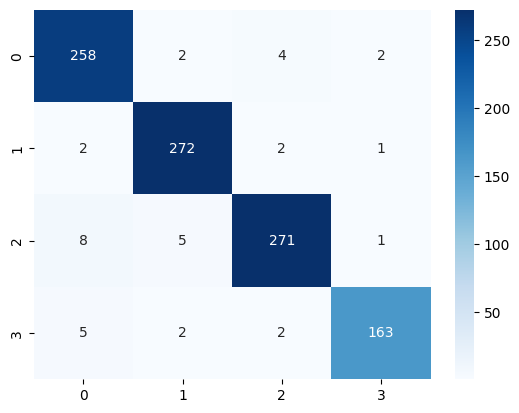

In [ ]:
# Text 모델 저장 잘 되었는지 불러와서 성능 확인
text_load_model = joblib.load('01012345678_2.joblib')
text_load_y_pred = text_load_model.predict(text_x_test_v)
text_cm = confusion_matrix(text_y_test, text_load_y_pred)
sns.heatmap(data=text_cm, annot=True, fmt='d', cmap='Blues')
plt.show()

# AICE Professional-3 Image 분류 모델 만들기

In [ ]:
# github img 데이터셋 불러오기
!wget https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip

--2025-03-31 13:31:07--  https://github.com/suku-7/AICE-Pro-share/raw/main/Flower_Classification_5class.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip [following]
--2025-03-31 13:31:07--  https://media.githubusercontent.com/media/suku-7/AICE-Pro-share/main/Flower_Classification_5class.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229731827 (219M) [application/zip]
Saving to: ‘Flower_Classification_5class.zip’

Flower_Classificati 100%[===================>] 219.09M   264MB/s    in 0.8s    

2025-03-31 13:31:35 

In [ ]:
# Colab 환경에서 압축 파일 업로드했기에 사용한 부분입니다.
!unzip Flower_Classification_5class.zip -d /content/

In [ ]:
# 시험에서는 압축을 별도로 풀지 않고 train과 test 이미지 경로를 바로 사용할 수 있도록 경로를 제공해줍니다.
# 예시1 : /content/flowers/train/
# 예시2 : /content/flowers/valid/

# img flower_photos에 데이터셋 종류 확인
!ls -l /content/flowers/flowers/flower_photos

total 12
drwxr-xr-x 7 root root 4096 Mar 31 13:32 test
drwxr-xr-x 7 root root 4096 Mar 31 13:32 train
drwxr-xr-x 7 root root 4096 Mar 31 13:32 validation


In [ ]:
# img jpg, jpeg, png, gif 뭐가 있는지 확인
# 다른 데이터셋중에는 jpg, jpeg가 혼합되어 사용된 경우가 있었어서 확인하게 되었습니다.
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep jpeg | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep png | wc -l
!ls -l /content/flowers/flowers/flower_photos/train/daisy | grep gif | wc -l

607
0
0
0


In [ ]:
# img valid 데이터셋 폴더내 꽃 종류 확인
!ls -l /content/flowers/flowers/flower_photos/validation

total 20
drwxr-xr-x 2 root root 4096 Mar 31 13:32 daisy
drwxr-xr-x 2 root root 4096 Mar 31 13:32 dandelion
drwxr-xr-x 2 root root 4096 Mar 31 13:32 roses
drwxr-xr-x 2 root root 4096 Mar 31 13:32 sunflowers
drwxr-xr-x 2 root root 4096 Mar 31 13:32 tulips


In [ ]:
# img test 데이터셋 폴더내 daisy 갯수 및 이미지 풀네임 확인
!ls -l /content/flowers/flowers/flower_photos/test/daisy

total 396
-rw-r--r-- 1 root root 36410 Apr 18  2021 10172379554_b296050f82_n.jpg
-rw-r--r-- 1 root root 24463 Apr 18  2021 1306119996_ab8ae14d72_n.jpg
-rw-r--r-- 1 root root 31422 Apr 18  2021 134409839_71069a95d1_m.jpg
-rw-r--r-- 1 root root 24030 Apr 18  2021 19813618946_93818db7aa_m.jpg
-rw-r--r-- 1 root root 17466 Apr 18  2021 3338077096_3a8ed0e2bc_m.jpg
-rw-r--r-- 1 root root 15072 Apr 18  2021 3552074420_2a0a7166db_m.jpg
-rw-r--r-- 1 root root 70320 Apr 18  2021 4141147800_813f660b47.jpg
-rw-r--r-- 1 root root 43385 Apr 18  2021 538920244_59899a78f8_n.jpg
-rw-r--r-- 1 root root 40516 Apr 18  2021 5973488341_50bdf6cee3_n.jpg
-rw-r--r-- 1 root root 86338 Apr 18  2021 8446495985_f72d851482.jpg


In [ ]:
# img train, valid 경로 지정
train_img_path = '/content/flowers/flowers/flower_photos/train/'
valid_img_path = '/content/flowers/flowers/flower_photos/validation/'

In [ ]:
"""
지금은 train 데이터셋, valid 데이터셋이 제공되어서 train-train, valid-valid를 사용했습니다.
train 데이터셋 하나만 제공되는 경우에는 valid 데이터셋을 만들기 위해서는
directory, validation_split, subset을 아래처럼 수정해주시면 됩니다.

train
directory=train_img_path,
validation_split=0.2,
subset='training'

valid
directory=train_img_path,
validation_split=0.2,
subset='validation'

"""

# img train dataset 만들기
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='training'
)
# img valid dataset 만들기
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_img_path,
    labels='inferred',
    #class_names=['cats', 'dogs'],
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    seed=42,
    shuffle=True,
    #validation_split=0.2,
    #subset='validation'
)

Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.


In [ ]:
# img 사전학습 모델인 MobileNetV3Large 사용
# 이미지 사이즈는 사전 학습된 모델 호환성 – 많은 딥러닝 모델(VGG16, ResNet 등)이
# 224x224 크기의 이미지를 입력으로 사용하도록 학습되었기 때문에 이렇게 사용했습니다.
img_base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224,224,3), weights='imagenet', include_top=False)
img_base_model.trainable=False

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# img dataset의 라벨 갯수 확인용 (5개)
train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# img 딥러닝 모델 제작
img_model = Sequential()
img_model.add(img_base_model)
img_model.add(Flatten())
img_model.add(Dense(256, activation=None))
img_model.add(BatchNormalization())
img_model.add(Activation('relu'))
img_model.add(Dropout(0.5))
img_model.add(Dense(5, activation='softmax'))

In [ ]:
#img 딥러닝 모델 compile
img_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# img 딥러닝 모델 훈련 fit
# img는 es3, mc3, history3 처럼 변수에 3을 붙여서 사용했습니다.
# 같은 코드 안에서 3개의 모델을 만들어서 비슷한 변수명에 숫자나, text, img를 붙였습니다.

es3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
mc3 = ModelCheckpoint('best_img_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history3 = img_model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[es3, mc3],
    verbose=1
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7627 - loss: 0.6905
Epoch 1: val_loss improved from inf to 0.45077, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 226ms/step - accuracy: 0.7633 - loss: 0.6887 - val_accuracy: 0.8750 - val_loss: 0.4508
Epoch 2/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9672 - loss: 0.1219
Epoch 2: val_loss improved from 0.45077 to 0.32265, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9673 - loss: 0.1216 - val_accuracy: 0.9125 - val_loss: 0.3227
Epoch 3/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9937 - loss: 0.0397
Epoch 3: val_loss improved from 0.32265 to 0.30810, saving model to best_img_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9937 - loss: 0.0396 - val_accuracy: 0.9125 - val_loss: 0.3081
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9976 - loss: 0.0248
Epoch 4: val_loss did not imp

In [ ]:
# 시험에서는 csv 파일에 image 파일명이 제공되지만,
# 현재의 환경처럼 csv 파일이 없는 경우 시험 환경과 비슷하게 하기 위해 파일을 만드는 부분입니다.
# 시험에서는 이 부분은 사용하지 않으셔도 될겁니다.

img_glob = sorted(glob.glob('/content/flowers/flowers/flower_photos/test/*/*jpg'))
img_file = [os.path.basename(path) for path in img_glob]
img_label = [os.path.basename(os.path.dirname(path)) for path in img_glob]

# img Test 데이터셋을 이용해서 DataFrame 만들기
img_df5 = pd.DataFrame()
img_df5['image'] = img_glob
img_df5['file'] = img_file
img_df5['label'] = img_label
img_df5.head(10)

,image,file,label
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy


In [ ]:
# img train dataset 라벨이 어떤게 들어있는지 확인
# imagedataset labels='inferred'를 설정해서 만들었기 때문에 a-z순으로 자동 저장됩니다.
# label의 순서를 임의로 조정해야한다면, 위의 imagedataset labels=None, Class_names=['cats', 'dogs']를 적으시면 됩니다.

train_dataset.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# 예측값 저장용 변수
img_predictions = []
# img test 데이터셋 폴더 경로
img_folder = '/content/flowers/flowers/flower_photos/test/'
# test 데이터셋 라벨 인코딩용 변수
img_label_to_class = {
    0:'daisy',
    1:'dandelion',
    2:'roses',
    3:'sunflowers',
    4:'tulips'
}

"""
시험에서는 csv를 '파일 경로+이미지'가 아니라 '이미지명'만 줬던거로 기억합니다.
img_folder 경로를 지정하고 img_path = os.path.join(img_folder, row['file'])
즉 폴더 경로 + 이미지명.jpg로만 사용해서 시험에서는 분류가 가능하지만
현재의 테스트 데이터셋은 Test/Daisy/이미지 상태로
시험의 테스트 데이터셋은 Test/이미지
와 다르게 꽃의 이름과 같은 하위 폴더가 있어서, 임의로 만든 row['image']이미지의 모든 경로를 사용합니다.

1. 위의 코드인 이미지의 경로를 확인해서 테스트 데이터셋 img_df5.csv를 만드는 방법
2. 이미지 폴더경로 + 이미지명 / img_df5['file'] 분류
3. 이미지 모든경로 / img_df5['image']로 분류
2번 방법만 알아도 시험을 보는데는 문제가 없을거로 생각되지만 변경사항이 있을 수 있으니
모두 다 사용방법을 다 숙달하고 외워서 가시는걸 추천드립니다.
이거는 다른거처럼 문법 레퍼런스를 보고 사용하는게 불가능해서 중점적으로 코드 연습을 했던 부분입니다.

"""

# 이미지를 한개씩 띄우고 예측한 값과 이미지명을 알려줍니다.
# img_df5.csv 기준 위에서 부터 순서대로 모델을 예측하고 분류해줍니다.
for i, row in img_df5.iterrows():
  img_path = row['image']
  #img_path = os.path.join(img_folder, row['file'])
  img = tf.keras.utils.load_img(img_path, target_size=(224,224))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  img_pred_t = img_model.predict(img_array, verbose=0)
  img_pred_label = np.argmax(img_pred_t)
  img_pred_class = img_label_to_class.get(img_pred_label, 'None')
  img_predictions.append(img_pred_label)

  plt.imshow(img)
  plt.title(f'Predict : {img_pred_label}({img_pred_class}) \n {os.path.basename(img_path)}')
  plt.axis('off')
  plt.show()

In [ ]:
# img 모델의 예측값을 csv파일에 추가해줍니다.
img_df5['pred'] = img_predictions
img_df5.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,0
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,0
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,0
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,0
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,0
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,0
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,0
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,0
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,0
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,0


In [ ]:
# img 예측한 값의 라벨을 수정해줍니다.
img_df5['pred'] = img_df5['pred'].map(img_label_to_class)
img_df5.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,daisy


In [ ]:
# img 모델의 성능은 0.86이 나왔네요
# 시험에서는 테스트 데이터셋의 라벨이 없기 때문에 불필요한 부분입니다.
img_correct_count = sum(img_df5['label']==img_df5['pred'])
img_total_count = len(img_df5)
img_model_accuracy = img_correct_count/img_total_count
print(f'img_model_accuracy : {img_model_accuracy:.2f}')

img_model_accuracy : 0.86


In [ ]:
# img 테스트 데이터셋.csv를 저장합니다.
img_df5.to_csv('01012345678_3.csv', index=False, encoding='utf-8')
img_df6 = pd.read_csv('01012345678_3.csv')
img_df6.head(10)

,image,file,label,pred
0,/content/flowers/flowers/flower_photos/test/da...,10172379554_b296050f82_n.jpg,daisy,daisy
1,/content/flowers/flowers/flower_photos/test/da...,1306119996_ab8ae14d72_n.jpg,daisy,daisy
2,/content/flowers/flowers/flower_photos/test/da...,134409839_71069a95d1_m.jpg,daisy,daisy
3,/content/flowers/flowers/flower_photos/test/da...,19813618946_93818db7aa_m.jpg,daisy,daisy
4,/content/flowers/flowers/flower_photos/test/da...,3338077096_3a8ed0e2bc_m.jpg,daisy,daisy
5,/content/flowers/flowers/flower_photos/test/da...,3552074420_2a0a7166db_m.jpg,daisy,daisy
6,/content/flowers/flowers/flower_photos/test/da...,4141147800_813f660b47.jpg,daisy,daisy
7,/content/flowers/flowers/flower_photos/test/da...,538920244_59899a78f8_n.jpg,daisy,daisy
8,/content/flowers/flowers/flower_photos/test/da...,5973488341_50bdf6cee3_n.jpg,daisy,daisy
9,/content/flowers/flowers/flower_photos/test/da...,8446495985_f72d851482.jpg,daisy,daisy


In [ ]:
# img 딥러닝 모델을 저장해줍니다.
img_model.save('01012345678_3.h5')

In [ ]:
# 수고하셨습니다! 코드 내용과 csv, 모델 저장등을 검토 하고서 최종 제출 누르시면 됩니다.


## =====================================================================

##이미지 다중분류 (Ver.2)

In [ ]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [ ]:
# 약 3,700장의 꽃 사진 데이터세트를 사용합니다.
# 아래 데이터 가져오기 그냥 사용합니다.

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
# 이미지 패스 지정
img_path = '/root/.keras/datasets/flower_photos/flower_photos/'

In [ ]:
!ls -l /root/.keras/datasets/flower_photos/flower_photos

total 608
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips


In [ ]:
# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             #label_mode="int",   # binary , categorical
                                             batch_size=32,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# Test Dataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             #label_mode="int",   # binary , categorical
                                             batch_size=32,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
########### 실행할 일이 없어야......
### 위에서 수행한 데이터셋 분류가 정상적으로 5개로 분류되지 않을 경우 label_mode="int"로 수정 후, 아래 수행
import tensorflow as tf
import pathlib
# 4. 데이터셋의 레이블을 명시적으로 원-핫 인코딩하는 함수 정의
def preprocess_image_and_label(image, label):
    # tf.one_hot을 사용하여 레이블을 원-핫 인코딩
    label = tf.one_hot(label, depth=5)
    return image, label

# Dataset의 map 함수를 사용하여 레이블을 원-핫 인코딩 적용
train_ds = train_ds.map(preprocess_image_and_label)
test_ds = test_ds.map(preprocess_image_and_label)

# 데이터셋에서 배치 하나 확인 (원-핫 인코딩 확인용)
for image_batch, labels_batch in train_ds.take(1):
    print(f"훈련 이미지 배치 형태: {image_batch.shape}")
    print(f"훈련 레이블 배치 형태: {labels_batch.shape}") # 이제 (None, num_classes) 형태여야 합니다.
    break

훈련 이미지 배치 형태: (32, 224, 224, 3)
훈련 레이블 배치 형태: (32, 5)


In [ ]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
base_model.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x=tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x=base_model(x, training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#이미지 갯수 5개
output= tf.keras.layers.Dense(5, activation='softmax')(x)

model=tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=3)
mc = ModelCheckpoint('mc.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(
    train_ds, validation_data=test_ds, epochs=50, callbacks=[es,mc], batch_size=64,
)

Epoch 1/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9314 - loss: 0.2308
Epoch 1: val_loss improved from 0.32998 to 0.32626, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9314 - loss: 0.2309 - val_accuracy: 0.8924 - val_loss: 0.3263
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9344 - loss: 0.2234
Epoch 2: val_loss improved from 0.32626 to 0.32191, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9345 - loss: 0.2233 - val_accuracy: 0.8924 - val_loss: 0.3219
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9426 - loss: 0.2062
Epoch 3: val_loss improved from 0.32191 to 0.31726, saving model to mc.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9426 - loss: 0.2063 - val_accuracy: 0.8924 - val_loss: 0.3173
Epoch 4/50
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9456 - loss: 0.1974
Epoch 4: val_loss improved from 0.31726 to 0.31231, saving model to mc.keras
92/9

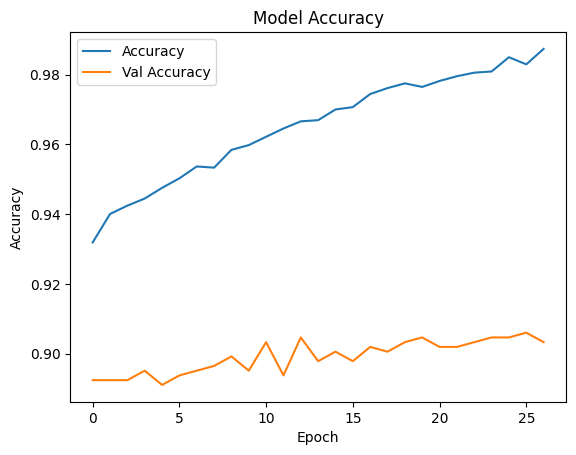

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 5)


In [ ]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[54.785713, 52.785713, 13.785714],
       [54.      , 52.      , 13.      ],
       [54.      , 52.      , 13.      ],
       [54.5     , 52.5     , 13.5     ],
       [55.928574, 53.928574, 14.928572],
       [55.642857, 53.642857, 14.642857],
       [55.      , 53.      , 14.785714],
       [56.214287, 54.214287, 16.214287],
       [57.      , 55.      , 17.      ],
       [57.      , 54.      , 19.      ]], dtype=float32)>

In [ ]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

from keras.preprocessing import image

In [ ]:
def predict_images_in_directory(model, folder_path, img_width, img_height):
    results = []
    images = []
    filenames = []

    # 디렉토리 내의 모든 이미지 파일 로드
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # 이미지 로드 및 전처리
        img = image.load_img(img_path)
        img = img.numpy().reshape(-1, 224,224,3)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)

        images.append(img_array)
        filenames.append(filename)

    # 배치 처리를 위해 이미지 스택 생성
    images = np.vstack(images)

    # 예측 수행
    predictions = model.predict(images)

    # 결과 저장
    for filename, pred in zip(filenames, predictions):
        results.append([filename, pred])

    return results

In [ ]:
!ls -al /root/.keras/datasets/flower_photos/flower_photos/

total 616
drwxr-x--- 7 270850 5000   4096 Feb 10  2016 .
drwxr-xr-x 3 root   root   4096 Jun 22 23:59 ..
drwx------ 2 270850 5000  36864 Feb 10  2016 daisy
drwx------ 2 270850 5000  49152 Feb 10  2016 dandelion
-rw-r----- 1 270850 5000 418049 Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36864 Feb 10  2016 roses
drwx------ 2 270850 5000  36864 Feb 10  2016 sunflowers
drwx------ 2 270850 5000  40960 Feb 10  2016 tulips


In [ ]:
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
results = predict_images_in_directory(model, img_path + 'dandelion')
print(results.count(1))
# 결과 출력 (처음 5개만)
for filename, flower_type in results:
    print(f"파일명: {filename}, 꽃종류: {flower_type}")

In [ ]:
import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results, columns=['filename', 'predicted_flower'])

csv_filename = f'flower_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측된 꽃 종류별 개수:")
print(df['predicted_flower'].value_counts())

결과가 flower_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
                      filename predicted_flower
0    3991962484_085ba2da94.jpg        dandelion
1  9293460423_7fbb1e3c32_n.jpg        dandelion
2      61242541_a04395e6bc.jpg        dandelion
3   17574213074_f5416afd84.jpg        dandelion
4  6208857436_14a65fe4af_n.jpg        dandelion

예측된 꽃 종류별 개수:
predicted_flower
dandelion     880
daisy           8
sunflowers      8
tulips          2
Name: count, dtype: int64


## =====================================================================

## =====================================================================

## 이미지 이중분류

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

!unzip cats_and_dogs_filtered.zip

In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
!pwd
!ls /content/cats_and_dogs_filtered/train
!ls /content/cats_and_dogs_filtered/validation

/content
cats  dogs
cats  dogs


In [ ]:
input_shape = (224, 224, 3)
num_classes=2

In [ ]:
img_path = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(img_path, 'train')
validation_dir = os.path.join(img_path, 'validation')

In [ ]:
# image_dataset_from_directory 함수 활용하여
# 이미지 폴더 밑의 이미지들에 대해 원핫인코딩된 labeling수행, 이미지 배치, 셔플 수행

batch_size=32
image_size=(224,224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=image_size,
    seed=42
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=validation_dir,
    label_mode='binary',
    batch_size=batch_size,
    image_size=image_size,
    seed=42
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


/tmp/ipython-input-10-2601659455.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_idx = int(labels[i].numpy())


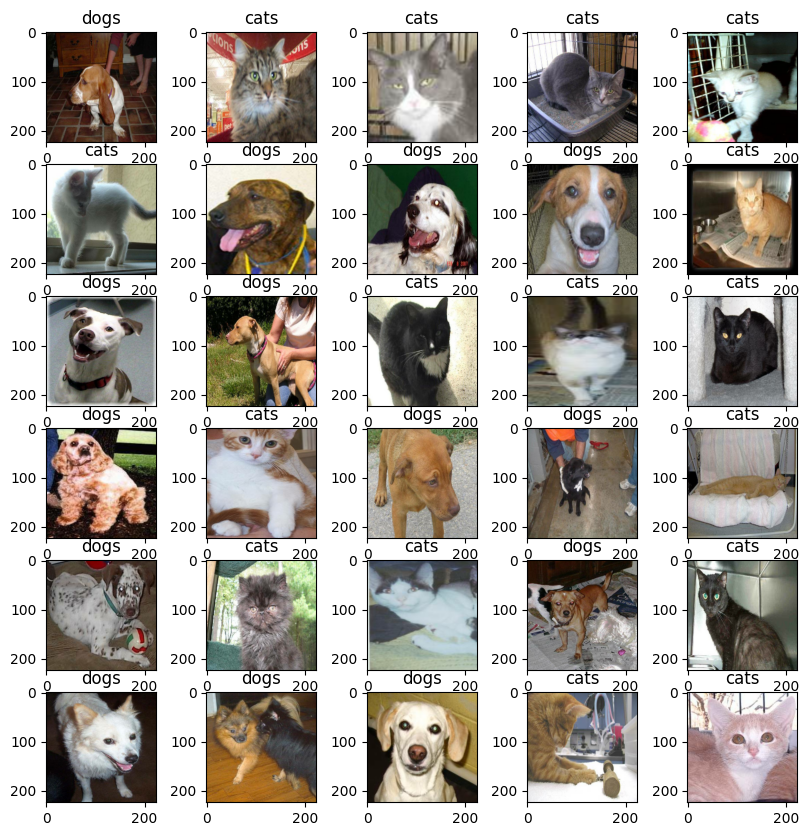

In [ ]:
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images,labels in train_ds.take(1):
  for i in range(30):
    ax=plt.subplot(6, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_idx = int(labels[i].numpy())
    plt.title(class_names[label_idx])
    plt.axis=("off")

In [ ]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
x = base_model(x, training=False)
x= tf.keras.layers.GlobalAveragePooling2D()(x)  #3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D

#이미지 갯수 5개
#output = tf.keras.layers.Dense(5, activation='softmax')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0003),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3, mode='min')
mc = ModelCheckpoint('my_checkpint.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[es,mc]
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8114 - loss: 0.4755
Epoch 1: val_loss improved from inf to 0.19389, saving model to my_checkpint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.8126 - loss: 0.4738 - val_accuracy: 0.9690 - val_loss: 0.1939
Epoch 2/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9704 - loss: 0.1784
Epoch 2: val_loss improved from 0.19389 to 0.11527, saving model to my_checkpint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9704 - loss: 0.1778 - val_accuracy: 0.9800 - val_loss: 0.1153
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9750 - loss: 0.1188
Epoch 3: val_loss improved from 0.11527 to 0.08646, saving model to my_checkpint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9750 - loss: 0.1186 - val_accuracy: 0.9820 - val_loss: 0.0865
Epoch 4/10
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9832 - loss: 0.0895
Epoch 4: val_loss improved from 0.08646 to 0.07148, s

In [ ]:
#체크포인트 저장된 모델 저장하기
# 1. 체크포인트에서 가중치 로드

model.load_weights('my_checkpint.keras')

# 3. 전체 모델로 저장
# model.save('complete_model')  # SavedModel 형식
# 또는
model.save('complete_model.h5')  # HDF5 형식

history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

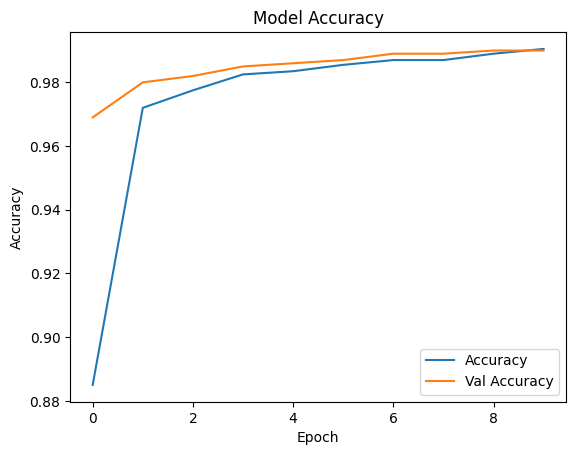

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

In [ ]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인
batch_img, batch_label = next(iter(test_ds))

In [ ]:
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 1)


In [ ]:
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[238.125 , 248.    , 188.0625],
       [240.5625, 247.625 , 189.    ],
       [243.3125, 245.375 , 189.3125],
       [243.5625, 242.25  , 192.1875],
       [241.875 , 240.5625, 199.5   ],
       [241.    , 242.375 , 214.    ],
       [237.75  , 247.0625, 231.1875],
       [232.3125, 247.0625, 249.    ],
       [215.75  , 238.9375, 253.125 ],
       [200.75  , 227.5   , 246.5625]], dtype=float32)>

In [ ]:
i=1
plt.figure(figsize=(16,30))
for img, label in list(zip(batch_img, batch_label)):
  pred = model.predict(img.numpy().reshape(-1,224,224,3), verbose=0)
  # pred는 [[확률]] 형태이므로 첫 번째 (유일한) 확률 값을 가져옵니다.
  predicted_probability = pred[0][0] # pred가 [[0.1234]] 형태일 때 0.1234 값을 가져옴
  # 임계값 0.5를 기준으로 클래스 결정 (이진 분류)
  pred_t = 1 if predicted_probability > 0.5 else 0

  true_t = int(label.numpy()[0])
  #pred_t = np.argmax(pred)
  plt.subplot(8,4,i)
  #plt.title(f"Pred Valud: {pred_t}, (Prob: {predicted_probability:.2f}")
  #plt.title(f"True Value:{np.argmax(label)}, Pred Valud: {pred_t}")
  plt.title(f"True Value:{true_t}, Pred Valud: {pred_t}")
  plt.imshow(img/255)
  i=i+1

In [ ]:
i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

from keras.preprocessing import image

In [ ]:
def predict_images_in_directory(model, img_path, batch_size=32):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 전처리
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            image_files.append(filename)
            image_arrays.append(img_array)

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)
    predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
test_dir = os.path.join(validation_dir, 'cats')
results = predict_images_in_directory(model, test_dir)
print(results.count(1))
# 결과 출력 (처음 5개만)
for filename, type in results:
    print(f"파일명: {filename}, 종류: {type}")

In [ ]:
def predict_images_in_directory_binary(model, img_path, class_names, batch_size=32, threshold=0.5):
    class_names = train_ds.class_names
    print("클래스 매핑:", dict(enumerate(class_names)))

    image_files = []
    image_arrays = []

    # 이미지 수집 및 전처리
    # Rescaling 레이어는 모델 내부에 있으므로 여기서는 추가 전처리 불필요 (load_img, img_to_array만 사용)
    for filename in os.listdir(img_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_file_path = os.path.join(img_path, filename)

            # 이미지 로드 및 리사이즈
            img = tf.keras.preprocessing.image.load_img(
                img_file_path,
                target_size=(224, 224) # 모델 입력 크기와 일치
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            # MobileNetV2 입력 스케일링 (1./127.5, offset=-1)은 모델 내부에 Rescaling 레이어로 처리되므로
            # 여기서는 추가적으로 수동 스케일링할 필요가 없습니다.

            image_files.append(filename)
            image_arrays.append(img_array)

    if not image_arrays:
        print(f"경로 {img_path}에서 유효한 이미지를 찾을 수 없습니다.")
        return []

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)

    # 한 번에 예측 수행
    # 이진 분류 모델의 predict 결과는 (배치_크기, 1) 형태의 확률 값입니다.
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)

    # 예측된 확률을 기반으로 클래스 결정
    # predictions는 (num_images, 1) 형태이므로 [:, 0]으로 첫 번째 (유일한) 차원을 가져옴
    predicted_classes = []
    for prob in predictions[:, 0]: # 각 이미지에 대한 단일 확률 값
        if prob > threshold:
            predicted_classes.append(class_names[1]) # 긍정 클래스 (예: dog)
        else:
            predicted_classes.append(class_names[0]) # 부정 클래스 (예: cat)

    # 결과 생성
    results = list(zip(image_files, predicted_classes))

    return results

# 사용 예시
# 가상의 이진 분류 모델과 클래스 이름을 가정합니다.
# 실제 모델은 dogs vs cats와 같은 이진 분류를 위해 sigmoid 활성화 함수를 사용해야 합니다.

# 예시: train_ds가 이진 분류용으로 생성된 경우
# 예를 들어, train_ds.class_names가 ['cat', 'dog']와 같이 2개 클래스를 가진다고 가정
# class_names_for_binary = train_ds.class_names
# 혹은 직접 정의
class_names_for_binary = ['cat', 'dog'] # 예시: 0이 'cat', 1이 'dog'을 의미한다고 가정

# 'validation_dir'이라는 변수가 정의되어 있다고 가정
# test_dir 경로도 이진 분류의 단일 클래스 폴더가 아닌,
# 예측하고자 하는 이미지들이 직접 들어있는 폴더여야 합니다.
# (예: test_images/test_dog.jpg, test_images/test_cat.jpg)
# 임시 테스트 디렉토리 생성 (실제 사용 시에는 존재하는 경로로 변경)
temp_test_images_dir = '/content/cats_and_dogs_filtered/validation/cats/'
#temp_test_images_dir = '/content/cats_and_dogs_filtered/validation/dogs/'

# 이제 함수 호출
results_binary = predict_images_in_directory_binary(model, temp_test_images_dir, class_names=class_names_for_binary)

# 결과 출력
if results_binary:
    print("\n----- 예측 결과 (이진 분류) -----")
    for filename, predicted_type in results_binary[:20]: # 처음 20개만
        print(f"파일명: {filename}, 예측된 종류: {predicted_type}")
    print(f"\n총 예측된 이미지 수: {len(results_binary)}")
else:
    print("예측할 이미지를 찾을 수 없거나 예측 결과가 없습니다.")

In [ ]:
import pandas as pd
# DataFrame 생성
df = pd.DataFrame(results, columns=['filename', 'predicted_type'])

csv_filename = f'cat_and_docs_predictions.csv'

# CSV 파일로 저장
df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
print(f"결과가 {csv_filename}에 저장되었습니다.")

# 저장된 결과 확인
print("\n저장된 데이터 미리보기:")
print(df.head())

# 꽃 종류별 개수 확인
print("\n예측 종류별 개수:")
print(df['predicted_type'].value_counts())

결과가 flower_predictions.csv에 저장되었습니다.

저장된 데이터 미리보기:
       filename predicted_type
0  cat.2341.jpg           cats
1  cat.2303.jpg           cats
2  cat.2215.jpg           cats
3  cat.2030.jpg           cats
4  cat.2105.jpg           cats

예측 종류별 개수:
predicted_type
cats    500
Name: count, dtype: int64
